In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import shutil, os
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# When model neeeds to be updated

In [26]:
train_on_gpu = torch.cuda.is_available()

In [27]:
playlists = pd.read_csv('./Dataset/2023_spotify_ds1.csv')
playlists = playlists[['pid', 'track_name']]

# get the new playlist from user
playlist2 = pd.read_csv('./Dataset/2023_spotify_ds2.csv')
playlist2 = playlist2[['pid', 'track_name']]
lucky_pid = playlist2.pid.sample(1).values[0]
new_playlist = playlist2[playlist2.pid == lucky_pid]

# update the playlist
playlists = pd.concat([playlists, new_playlist])

In [28]:
num_epochs = 30
learning_rate = 0.01
batch_size = 128
n_users = len(playlists.pid.unique())
n_items = len(playlists.track_name.unique())
n_factors = 20

In [29]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=50):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_factors.weight.data.uniform_(0,0.05)
        self.item_factors.weight.data.uniform_(0,0.05)
        
    def forward(self, user, item):
        return (self.user_factors(user) * self.item_factors(item)).sum(1)
    
    def predict(self, user, item):
        return self.forward(user, item)

In [30]:
class Loader(Dataset):
    def __init__(self, data):
        self.data = data.copy()
        
        self.pid = self.data.pid.unique()
        self.track_name = self.data.track_name.unique()
        
        # index
        self.pid2idx = {o:i for i,o in enumerate(self.pid)}
        self.track_name2idx = {o:i for i,o in enumerate(self.track_name)}
        
        # reverse index
        self.idx2pid = {i:o for o,i in self.pid2idx.items()}
        self.idx2track_name = {i:o for o,i in self.track_name2idx.items()}
        
        # update data
        self.data.pid = self.data.pid.apply(lambda x: self.pid2idx[x])
        self.data.track_name = self.data.track_name.apply(lambda x: self.track_name2idx[x])
        
        # keep only pid and track_name
        self.x = self.data.values
        self.y = [1 for _ in range(len(self.data))]
        
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y).type(torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [31]:
shutil.rmtree('./model', ignore_errors=True)
os.makedirs('./model')
model = MatrixFactorization(n_users, n_items, n_factors)
if train_on_gpu:
    model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

playlists = Loader(playlists)
train_size = int(0.8 * len(playlists))
test_size = len(playlists) - train_size

train_set, test_set = random_split(playlists, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

average_train_losses = []
average_test_losses = []
for i in tqdm(range(num_epochs)):
    train_losses = []
    test_losses = []
    
    model.train()
    for x, y in train_loader:
        if train_on_gpu:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        output = model(x[:, 0], x[:, 1])
        loss = criterion(output, y)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.cuda()
            y = y.cuda()
            output = model(x[:, 0], x[:, 1])
            loss = criterion(output, y)
            test_losses.append(loss.item())
    
    # print losses
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_test_loss = sum(test_losses) / len(test_losses)
    average_train_losses.append(avg_train_loss)
    average_test_losses.append(avg_test_loss)
    print(f'epoch: {i:3} train_loss: {avg_train_loss:10.8f} test_loss: {avg_test_loss:10.8f}')
    
    # save the dict of the track_name and track_name embedding to pickle file with epoch number
    track_name_embedding = model.item_factors.weight.data.cpu().numpy()
    track_name_embedding = pd.DataFrame(track_name_embedding)
    track_name_embedding.index = playlists.idx2track_name.values()
    track_name_embedding.to_pickle(f'./model/track_name_embedding_{i}.pkl')

  3%|▎         | 1/30 [00:16<07:57, 16.46s/it]

epoch:   0 train_loss: 0.05970229 test_loss: 0.02624745


  7%|▋         | 2/30 [00:31<07:13, 15.48s/it]

epoch:   1 train_loss: 0.03117276 test_loss: 0.03481788


 10%|█         | 3/30 [00:49<07:32, 16.76s/it]

epoch:   2 train_loss: 0.03418233 test_loss: 0.03405706


 13%|█▎        | 4/30 [01:06<07:22, 17.00s/it]

epoch:   3 train_loss: 0.03195950 test_loss: 0.03100812


 17%|█▋        | 5/30 [01:23<07:03, 16.94s/it]

epoch:   4 train_loss: 0.03216381 test_loss: 0.03303843


 20%|██        | 6/30 [01:41<06:50, 17.09s/it]

epoch:   5 train_loss: 0.03160948 test_loss: 0.03260681


 23%|██▎       | 7/30 [01:56<06:16, 16.37s/it]

epoch:   6 train_loss: 0.03145268 test_loss: 0.03239728


 27%|██▋       | 8/30 [02:09<05:41, 15.52s/it]

epoch:   7 train_loss: 0.02940691 test_loss: 0.02952498


 30%|███       | 9/30 [02:24<05:23, 15.39s/it]

epoch:   8 train_loss: 0.02681306 test_loss: 0.02285092


 33%|███▎      | 10/30 [02:40<05:12, 15.61s/it]

epoch:   9 train_loss: 0.02262822 test_loss: 0.02114899


 37%|███▋      | 11/30 [02:54<04:44, 14.96s/it]

epoch:  10 train_loss: 0.01869848 test_loss: 0.01791058


 40%|████      | 12/30 [03:04<04:02, 13.48s/it]

epoch:  11 train_loss: 0.01612739 test_loss: 0.01528524


 43%|████▎     | 13/30 [03:19<03:59, 14.07s/it]

epoch:  12 train_loss: 0.01333613 test_loss: 0.01279632


 47%|████▋     | 14/30 [03:36<03:58, 14.90s/it]

epoch:  13 train_loss: 0.01169346 test_loss: 0.01161106


 50%|█████     | 15/30 [03:51<03:44, 14.95s/it]

epoch:  14 train_loss: 0.01058498 test_loss: 0.01190538


 53%|█████▎    | 16/30 [04:06<03:28, 14.87s/it]

epoch:  15 train_loss: 0.01436208 test_loss: 0.01471592


 57%|█████▋    | 17/30 [04:19<03:04, 14.22s/it]

epoch:  16 train_loss: 0.00829584 test_loss: 0.00415314


 60%|██████    | 18/30 [04:32<02:47, 13.98s/it]

epoch:  17 train_loss: 0.02983732 test_loss: 0.05705914


 63%|██████▎   | 19/30 [04:48<02:38, 14.44s/it]

epoch:  18 train_loss: 0.01486895 test_loss: 0.00233417


 67%|██████▋   | 20/30 [05:03<02:26, 14.67s/it]

epoch:  19 train_loss: 0.00145605 test_loss: 0.00180212


 70%|███████   | 21/30 [05:20<02:18, 15.34s/it]

epoch:  20 train_loss: 0.04157042 test_loss: 0.04429296


 73%|███████▎  | 22/30 [05:33<01:57, 14.74s/it]

epoch:  21 train_loss: 0.01129247 test_loss: 0.00190986


 77%|███████▋  | 23/30 [05:49<01:45, 15.09s/it]

epoch:  22 train_loss: 0.00122622 test_loss: 0.00168523


 80%|████████  | 24/30 [06:06<01:34, 15.77s/it]

epoch:  23 train_loss: 0.03570627 test_loss: 0.05990652


 83%|████████▎ | 25/30 [06:22<01:18, 15.68s/it]

epoch:  24 train_loss: 0.01457878 test_loss: 0.00225846


 87%|████████▋ | 26/30 [06:38<01:03, 15.79s/it]

epoch:  25 train_loss: 0.00130370 test_loss: 0.00135421


 90%|█████████ | 27/30 [06:53<00:46, 15.49s/it]

epoch:  26 train_loss: 0.03141873 test_loss: 0.07658777


 93%|█████████▎| 28/30 [07:07<00:30, 15.11s/it]

epoch:  27 train_loss: 0.01831306 test_loss: 0.00244593


 97%|█████████▋| 29/30 [07:24<00:15, 15.73s/it]

epoch:  28 train_loss: 0.00136562 test_loss: 0.00122738


100%|██████████| 30/30 [07:41<00:00, 15.40s/it]

epoch:  29 train_loss: 0.02067213 test_loss: 0.09622075


In [32]:
# find out the best model
best_epoch = np.argmin(average_test_losses)
print(f'best epoch: {best_epoch}, test_loss: {average_test_losses[best_epoch]}')

best epoch: 28, test_loss: 0.0012273848960397853


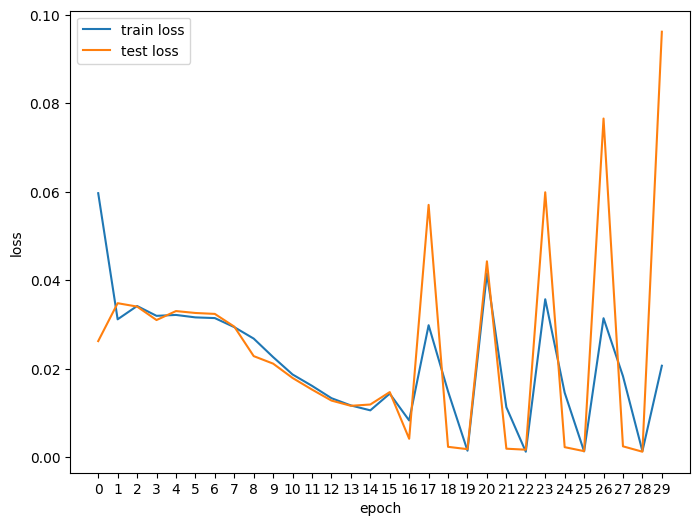

In [33]:
# plot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
x = np.arange(len(average_train_losses))
plt.plot(x, average_train_losses, label='train loss')
plt.plot(x, average_test_losses, label='test loss')
plt.xticks(x, x)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [34]:
# remove the other model
for i in range(num_epochs):
    if i != best_epoch:
        os.remove(f'./model/track_name_embedding_{i}.pkl')
        
# rename the best model
os.rename(f'./model/track_name_embedding_{best_epoch}.pkl', './model/track_name_embedding.pkl')

# When model does not need to be updated, directly get the recommendation.

In [75]:
# get the new playlist from user
playlist2 = pd.read_csv('./Dataset/2023_spotify_ds2.csv')
playlist2 = playlist2[['pid', 'track_name']]
lucky_pid = playlist2.pid.sample(1).values[0]
new_playlist = playlist2[playlist2.pid == lucky_pid]

In [76]:
# load the embedding pickle file
track_name_embedding = pd.read_pickle('./model/track_name_embedding.pkl')
candidate_track_name = track_name_embedding.index

valid_track_name_count = 0
valid_track_name = []
for i in new_playlist['track_name']:
    if i in track_name_embedding.index:
        valid_track_name.append(i)
        try:
            candidate_track_name = candidate_track_name.drop(i)
        except:    
            pass

print(f'valid track_name takes up {len(valid_track_name) / len(new_playlist) * 100:.2f}%')

valid track_name takes up 98.13%


In [77]:
# Calculate the mean of the new playlist embedding for the seen track_name
valid_new_playlist = new_playlist[new_playlist.track_name.isin(valid_track_name)]
new_playlist_embedding = track_name_embedding.loc[valid_new_playlist.track_name].mean()

candidate_track_name_embedding = track_name_embedding.loc[candidate_track_name]

In [78]:
# calculate the cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(candidate_track_name_embedding, new_playlist_embedding.values.reshape(1, -1))
similarity = similarity.reshape(-1)

top_10_idx = similarity.argsort()[-10:][::-1]
top_10_track_name = track_name_embedding.iloc[top_10_idx].index
print(top_10_track_name)

Index(['Everytime We Touch - Radio Edit',
       'Rocket Man (I Think It's Going To Be A Long Long Time)',
       'Lay It All On Me (feat. Ed Sheeran)', 'Walk Like an Egyptian',
       'Tipsy - Club Mix', 'Lighters', 'Someone Like You', 'Colder Weather',
       'I Hold On', 'Everybody Wants To Rule The World'],
      dtype='object')
